https://www.kaggle.com/code/muhammadfaizan65/parking-lot-detection-counter

In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import ipywidgets as widgets

c:\Users\user\miniconda3\envs\forCUDA\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning:

Trying to unpickle estimator SVC from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



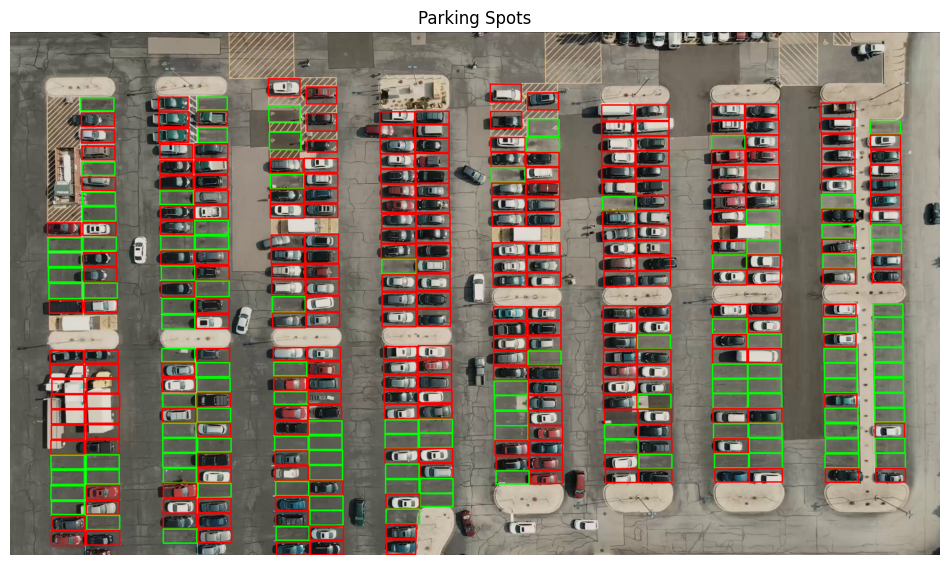

Video saved successfully at C:/data/archive/parking/processed_parking_test.mp4
Video size: 173244571 bytes


In [ ]:
EMPTY = True
NOT_EMPTY = False

# Load the pre-trained model
model_path = "C:/data/archive/parking/model/model.p"
MODEL = pickle.load(open(model_path, "rb"))


# Helper functions from util.py
def empty_or_not(spot_bgr):
    if spot_bgr is None or spot_bgr.size == 0:
        return NOT_EMPTY  # Treat invalid spots as occupied
    try:
        flat_data = []
        img_resized = resize(spot_bgr, (15, 15, 3))
        flat_data.append(img_resized.flatten())
        flat_data = np.array(flat_data)
        y_output = MODEL.predict(flat_data)
        return EMPTY if y_output == 0 else NOT_EMPTY
    except Exception as e:
        print(f"Error processing spot: {e}")
        return NOT_EMPTY  # Treat errors as occupied
    

def get_parking_spots_bboxes(connected_components):
    (totalLabels, label_ids, values, centroid) = connected_components
    slots = []
    coef = 1
    for i in range(1, totalLabels):
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)
        slots.append([x1, y1, w, h])
    return slots

# Load mask image
mask_img_path = "C:/data/archive/parking/mask_1920_1080.png"
mask_img = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)

# Find connected components in the mask image
connected_components = cv2.connectedComponentsWithStats(mask_img, connectivity=8, ltype=cv2.CV_32S)
parking_bboxes = get_parking_spots_bboxes(connected_components)

# EDA and visualization
def visualize_parking_spots(image, bboxes, title="Parking Spots"):
    for bbox in bboxes:
        x, y, w, h = bbox
        if w > 0 and h > 0:  # Ensure valid bounding box dimensions
            spot = image[y:y+h, x:x+w]
            if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                status = empty_or_not(spot)
                color = (0, 255, 0) if status == EMPTY else (0, 0, 255)
                cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Extract a frame from the video
def extract_frame_from_video(video_path, frame_number=0):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return frame
    else:
        raise ValueError("Unable to extract frame from video.")

# image visualization
video_path = "C:/data/archive/parking/parking_1920_1080_loop.mp4"
example_frame = extract_frame_from_video(video_path)
visualize_parking_spots(example_frame, parking_bboxes)


# Process video and detect parking spot status
def process_video(video_path, bboxes, model, output_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        for bbox in bboxes:
            x, y, w, h = bbox
            if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                spot = frame[y:y+h, x:x+w]
                if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                    status = empty_or_not(spot)
                    color = (0, 255, 0) if status == EMPTY else (0, 0, 255)
                    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        
        out.write(frame)
    
    cap.release()
    out.release()

# Process and save video
input_video_path = "C:/data/archive/parking/Parking_new.mp4"
output_video_path = "C:/data/archive/parking/processed_parking_test.mp4"
process_video(input_video_path, parking_bboxes, MODEL, output_video_path)


# Verify the video was saved correctly
if os.path.exists(output_video_path):
    print(f"Video saved successfully at {output_video_path}")
    # Check the size of the video
    video_size = os.path.getsize(output_video_path)
    if video_size > 0:
        print(f"Video size: {video_size} bytes")
        # Display the processed video using IPython widgets
        video_widget = widgets.Video.from_file(output_video_path)
        video_widget.width = 800
        video_widget.height = 600
        display(video_widget)
    else:
        print("The video file is empty.")
else:
    raise FileNotFoundError(f"Processed video not found at {output_video_path}")

# Save processed images with bounding boxes
def save_processed_images(image_paths, bboxes, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is None:
            continue
        for bbox in bboxes:
            x, y, w, h = bbox
            if w > 0 and h > 0:  # Ensure valid bounding box dimensions
                spot = image[y:y+h, x:x+w]
                if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                    status = empty_or_not(spot)
                    color = (0, 255, 0) if status == EMPTY else (0, 0, 255)
                    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(output_path, image)

# Process and save images
image_dir = "C:/data/archive/parking/clf-data"
empty_dir = os.path.join(image_dir, "empty")
not_empty_dir = os.path.join(image_dir, "not_empty")
output_image_dir = "C:/data/archive/parking/processed_images"

empty_images = [os.path.join(empty_dir, img) for img in os.listdir(empty_dir)]
not_empty_images = [os.path.join(not_empty_dir, img) for img in os.listdir(not_empty_dir)]
all_images = empty_images + not_empty_images

save_processed_images(all_images, parking_bboxes, output_image_dir)


# Interactive visualization using Plotly
def interactive_visualization(image, bboxes):
    fig = px.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for bbox in bboxes:
        x, y, w, h = bbox
        if w > 0 and h > 0:  # Ensure valid bounding box dimensions
            spot = image[y:y+h, x:x+w]
            if spot.shape[0] > 0 and spot.shape[1] > 0:  # Ensure valid spot dimensions
                status = empty_or_not(spot)
                color = "green" if status == EMPTY else "red"
                fig.add_shape(type="rect",
                              x0=x, y0=y, x1=x+w, y1=y+h,
                              line=dict(color=color, width=2))
    fig.update_layout(title="Interactive Parking Spot Detection", margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

# Example interactive visualization
interactive_visualization(example_frame, parking_bboxes)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed